In [ ]:
!git clone https://github.com/hunglc007/tensorflow-yolov4-tflite.git
!cd tensorflow-yolov4-tflite

# 06_YOLO_CAM

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

import cv2
import numpy as np
import matplotlib.pyplot as plt

import core.utils as utils
from core.config import cfg
from core.yolov4 import YOLO, decode, filter_boxes

2022-05-06 10:56:09.198507: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-06 10:56:11.506122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10417 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1
2022-05-06 10:56:11.507051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10417 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:06:00.0, compute capability: 6.1
2022-05-06 10:56:11.508036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/t

In [2]:
def get_anchors(anchors_path, tiny=False):
    anchors = np.array(anchors_path)
    if tiny:
        return anchors.reshape(2, 3, 2)
    else:
        return anchors.reshape(3, 3, 2)
    
def read_class_names(class_file_name):
    names = {}
    with open(class_file_name, 'r') as data:
        for ID, name in enumerate(data):
            names[ID] = name.strip('\n')
    return names

In [3]:
STRIDES = np.array(cfg.YOLO.STRIDES)
ANCHORS = get_anchors(cfg.YOLO.ANCHORS)
NUM_CLASS = len(read_class_names(cfg.YOLO.CLASSES))
XYSCALE = cfg.YOLO.XYSCALE 
input_size = 416
image_path = 'data/kite.jpg'
weights = 'data/yolov4.weights'
score_thres = 0.45
class_score = 0.25

In [4]:
input_layer = tf.keras.layers.Input([input_size, input_size, 3])
feature_maps = YOLO(input_layer, NUM_CLASS)
bbox_tensors = []
prob_tensors = []
for i, fm in enumerate(feature_maps):
    if i == 0:
        output_tensors = decode(fm, input_size // 8, NUM_CLASS, STRIDES, ANCHORS, i, XYSCALE)
    elif i == 1:
        output_tensors = decode(fm, input_size // 16, NUM_CLASS, STRIDES, ANCHORS, i, XYSCALE)
    else:
        output_tensors = decode(fm, input_size // 32, NUM_CLASS, STRIDES, ANCHORS, i, XYSCALE)
    bbox_tensors.append(output_tensors[0])
    prob_tensors.append(output_tensors[1])
    
pred_bbox = tf.concat(bbox_tensors, axis=1)
pred_prob = tf.concat(prob_tensors, axis=1)

boxes, pred_conf = filter_boxes(pred_bbox, pred_prob, score_threshold=score_thres, input_shape=tf.constant([input_size, input_size]))
pred = tf.concat([boxes, pred_conf], axis=-1)
model = tf.keras.Model(input_layer, [feature_maps, pred])
utils.load_weights(model, weights)
# model.summary()

In [5]:
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

image_data = cv2.resize(original_image, (input_size, input_size))
image_data = image_data / 255.

images_data = []
for i in range(1):
    images_data.append(image_data)
images_data = np.asarray(images_data).astype(np.float32)
batch_data = tf.constant(images_data)

In [6]:
feature_maps, pred_bbox = model.predict(batch_data)
boxes = pred_bbox[:, :, 0:4]
pred_conf = pred_bbox[:, :, 4:]
    
boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
    boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
    scores=tf.reshape(
        pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
    max_output_size_per_class=50,
    max_total_size=50,
    iou_threshold=0.45,
    score_threshold=0.25
)
pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]

2022-05-06 10:56:20.188699: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-05-06 10:56:20.410421: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-06 10:56:20.410968: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-06 10:56:20.411008: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-05-06 10:56:20.411729: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-06 10:56:20.411788: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [7]:
image = utils.draw_bbox(original_image, pred_bbox)

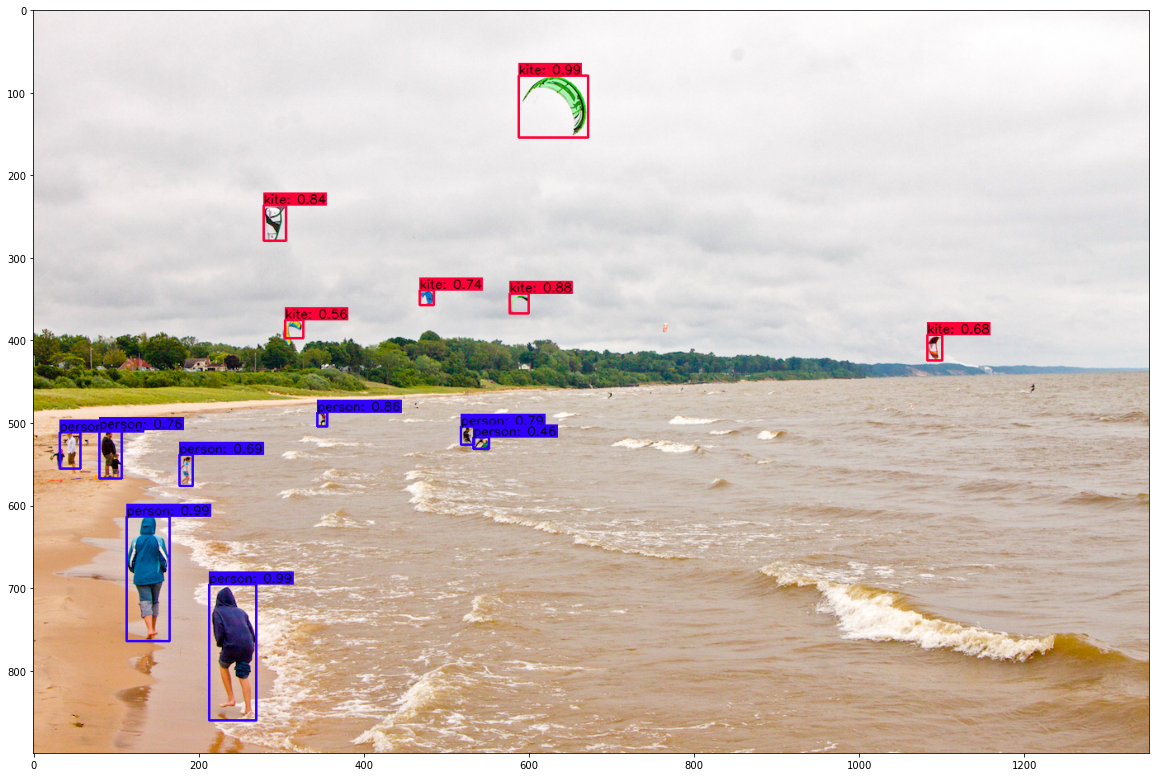

In [8]:
plt.figure(figsize=(20, 30))
plt.imshow(image/255)

In [9]:
classes

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0., 33.,  0., 33.,  0., 33.,  0.,  0.,  0., 33.,  0., 33., 33.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
      dtype=float32)>

In [25]:
class_id = 33
layers0 = tf.reshape(feature_maps[0], (-1, 5 + NUM_CLASS))
layers1 = tf.reshape(feature_maps[1], (-1, 5 + NUM_CLASS))
layers2 = tf.reshape(feature_maps[2], (-1, 5 + NUM_CLASS))
layers = tf.concat([layers0, layers1, layers2], axis=0)
score_max_v = max(layers[:, 4].numpy())  # compute max of score from all anchor
score_min_v = min(layers[:, 4].numpy())  # compute min of score from all anchor
class_max_v = max(layers[:, 5 + class_id].numpy())  # compute max of class from all anchor
class_min_v = min(layers[:, 5 + class_id].numpy())  # compute min of class from all anchor

all_attribution_mask = []
for j in range(3):  # layers
    layer_one = tf.reshape(feature_maps[j], (feature_maps[j].shape[0], 
                                             feature_maps[j].shape[1], 
                                             feature_maps[j].shape[2], 
                                             -1, 5+NUM_CLASS))
    # compute max of score from three anchor of the layer
    anchors_score_max = layer_one[0, ..., 4].numpy().max(-1)
    # compute max of class from three anchor of the layer
    anchors_class_max = layer_one[0, ..., 5+class_id].numpy().max(-1)

    scores = ((anchors_score_max - score_min_v) / (
            score_max_v - score_min_v))

    classes = ((anchors_class_max - class_min_v) / (
            class_max_v - class_min_v))

    ret = scores*classes
    attribution_mask = ((ret - ret.min()) / (ret.max() - ret.min()))
    attribution_mask = cv2.resize(attribution_mask, (image.shape[1], image.shape[0]))
    all_attribution_mask.append(attribution_mask)

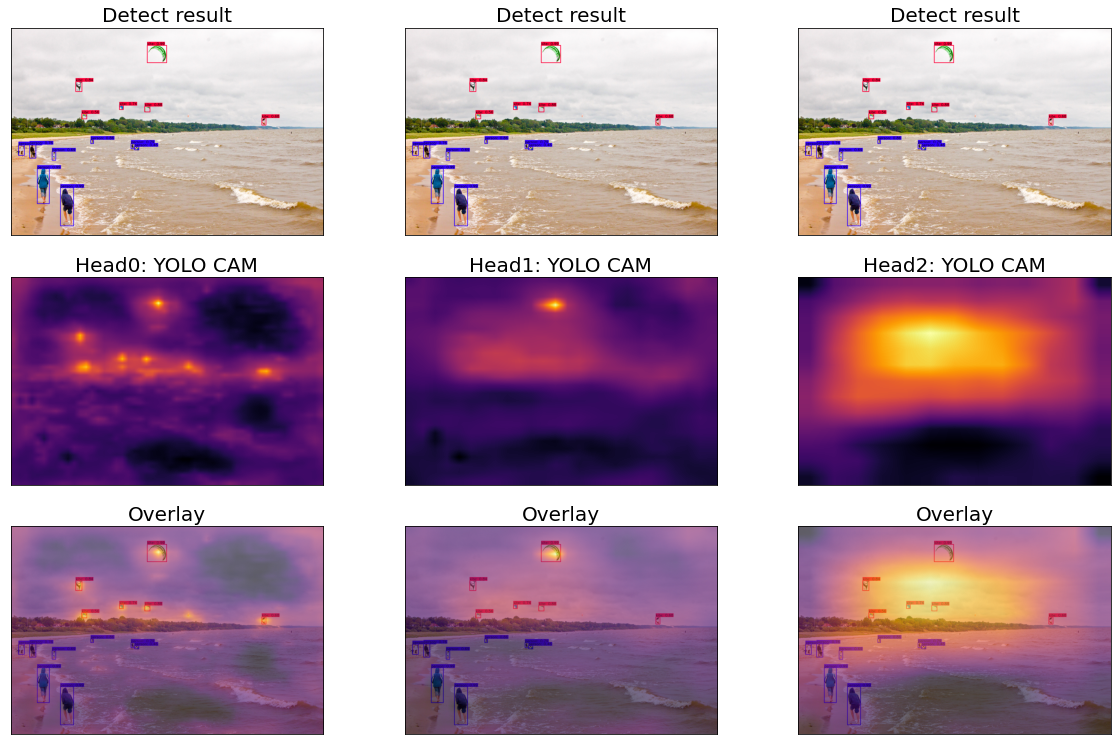

In [26]:
import matplotlib.cm as cm

fig, axs = plt.subplots(nrows=3, ncols=3, squeeze=False, figsize=(20, 13),
                        subplot_kw={'xticks':[], 'yticks':[]})

for i in range(3):
    axs[0, i].set_title('Detect result', fontsize=20)
    axs[0, i].imshow(image/255)

    axs[1, i].set_title(f'Head{i}: YOLO CAM', fontsize=20)
    axs[1, i].imshow(all_attribution_mask[i], cmap=cm.inferno)

    axs[2, i].set_title('Overlay', fontsize=20)
    axs[2, i].imshow(all_attribution_mask[i], cmap=cm.inferno)
    axs[2, i].imshow(image/255, alpha=0.4)

In [23]:
class_id = 0
layers0 = tf.reshape(feature_maps[0], (-1, 5 + NUM_CLASS))
layers1 = tf.reshape(feature_maps[1], (-1, 5 + NUM_CLASS))
layers2 = tf.reshape(feature_maps[2], (-1, 5 + NUM_CLASS))
layers = tf.concat([layers0, layers1, layers2], axis=0)
score_max_v = max(layers[:, 4].numpy())  # compute max of score from all anchor
score_min_v = min(layers[:, 4].numpy())  # compute min of score from all anchor
class_max_v = max(layers[:, 5 + class_id].numpy())  # compute max of class from all anchor
class_min_v = min(layers[:, 5 + class_id].numpy())  # compute min of class from all anchor

all_attribution_mask = []
for j in range(3):  # layers
    layer_one = tf.reshape(feature_maps[j], (feature_maps[j].shape[0], 
                                             feature_maps[j].shape[1], 
                                             feature_maps[j].shape[2], 
                                             -1, 5+NUM_CLASS))
    # compute max of score from three anchor of the layer
    anchors_score_max = layer_one[0, ..., 4].numpy().max(-1)
    # compute max of class from three anchor of the layer
    anchors_class_max = layer_one[0, ..., 5+class_id].numpy().max(-1)

    scores = ((anchors_score_max - score_min_v) / (
            score_max_v - score_min_v))

    classes = ((anchors_class_max - class_min_v) / (
            class_max_v - class_min_v))

    ret = scores*classes
    attribution_mask = ((ret - ret.min()) / (ret.max() - ret.min()))
    attribution_mask = cv2.resize(attribution_mask, (image.shape[1], image.shape[0]))
    all_attribution_mask.append(attribution_mask)

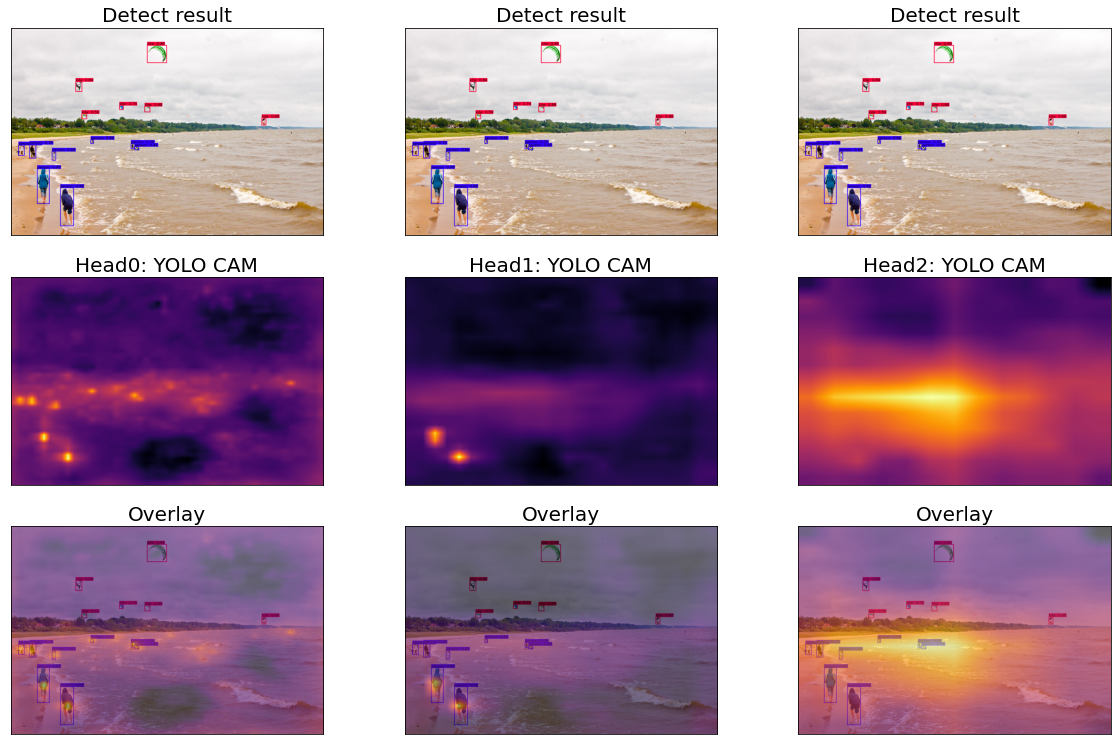

In [24]:
fig, axs = plt.subplots(nrows=3, ncols=3, squeeze=False, figsize=(20, 13),
                        subplot_kw={'xticks':[], 'yticks':[]})

for i in range(3):
    axs[0, i].set_title('Detect result', fontsize=20)
    axs[0, i].imshow(image/255)

    axs[1, i].set_title(f'Head{i}: YOLO CAM', fontsize=20)
    axs[1, i].imshow(all_attribution_mask[i], cmap=cm.inferno)

    axs[2, i].set_title('Overlay', fontsize=20)
    axs[2, i].imshow(all_attribution_mask[i], cmap=cm.inferno)
    axs[2, i].imshow(image/255, alpha=0.4)

### 練習時間：
#### 試試看用不同影像 (data/cat_and_dog.jpg) 來跑這個方法，並更改不同的 target_class_idx 看看模型關注哪個地方